# EDA 
Author: Huiting Song

## EDA - Monthly data of net generation for all utility-scale solar in Virginia
From Jan 2017 to Jan 2024

In [60]:
# Import packages
import pandas as pd
import sklearn
import numpy as np
import nltk
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [61]:
# Read CSV
net_gen = pd.read_csv("/Users/crystal/Desktop/ANLY5550/Data/Cleaned/EIA_net_generation.csv")
net_gen.head(10)

,Date,net_gen_electric_power
0,2017-01-01,15.0
1,2017-02-01,19.0
2,2017-03-01,23.0
3,2017-04-01,25.0
4,2017-05-01,28.0
5,2017-06-01,24.0
6,2017-07-01,29.0
7,2017-08-01,26.0
8,2017-09-01,25.0
9,2017-10-01,26.0


In [62]:
# descriptive statistics
net_gen.describe()

,net_gen_electric_power
count,85.000000
mean,199.164706
std,174.160630
min,15.000000
25%,66.000000
50%,116.000000
75%,307.000000
max,609.000000


### Figure 1 - Time series plot of net generation 

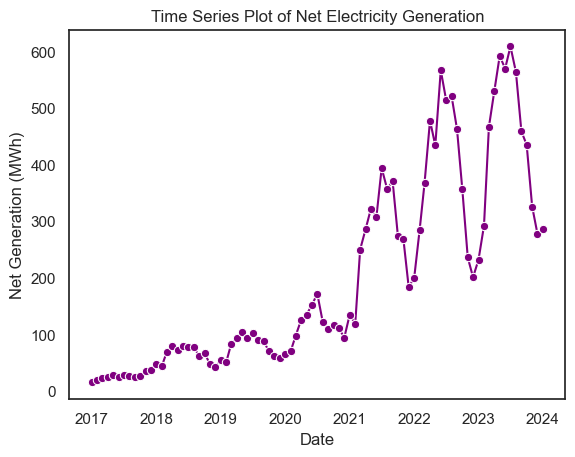

In [63]:
net_gen['Date'] = pd.to_datetime(net_gen['Date'])

# Setting plot style
sns.set(style="white")

# Plotting time series of net generation
sns.lineplot(x=net_gen['Date'], y=net_gen['net_gen_electric_power'], marker='o',color='purple')
plt.title('Time Series Plot of Net Electricity Generation')
plt.xlabel('Date')
plt.ylabel('Net Generation (MWh)')

plt.show()

**Observation:** Starting from 2017 and extending into early 2019, there's a gradual increase in net electricity generation. After a slight drop, there is a more pronounced increase starting from late 2019 through 2020. After 2021, the net generation increased dramatically but there is sharp dropdown in the year beginning. The overall trend is upward over these years, suggesting an increase in electricity production capacity from solar. The sharp drops, such as those occurring in 2021 and 2023, could be indicative of anomalies. These could result from data collection issues, actual drops in production due to maintenance or breakdowns, seasonal conditions, or external factors like economic downturns or energy conservation initiatives.

### Figure 2 -  Time series plot of Yearly comparison from 2019 to 2023

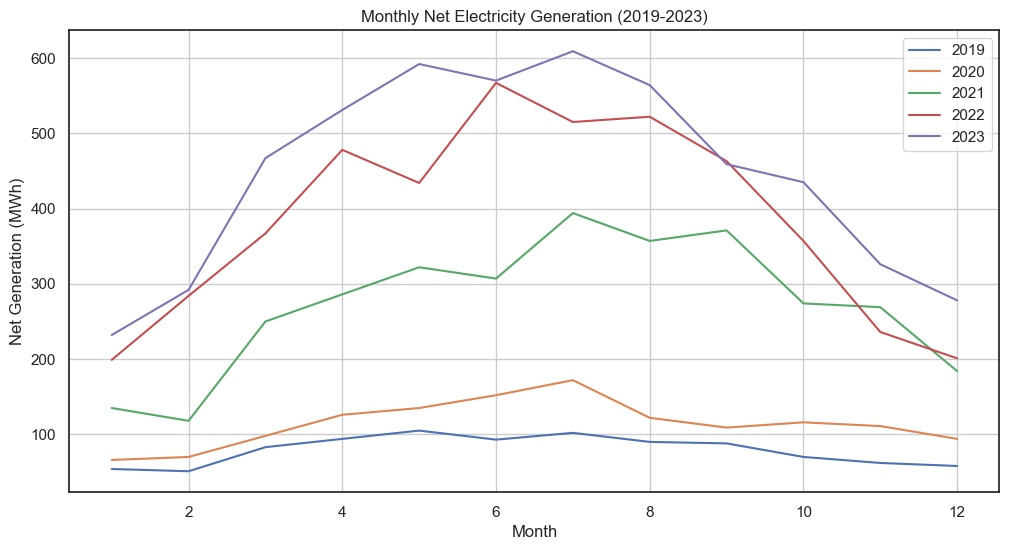

In [64]:
net_gen1 = net_gen.set_index('Date')

# Now filter the data for each year and plot it
plt.figure(figsize=(12, 6))

for year in range(2019, 2024):
    # Select the data for the year
    yearly_data = net_gen1[net_gen1.index.year == year]['net_gen_electric_power']
    plt.plot(yearly_data.index.month, yearly_data.values, label=str(year))

plt.title('Monthly Net Electricity Generation (2019-2023)')
plt.xlabel('Month')
plt.ylabel('Net Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

**Observation:** Each year shows its own trend with some commonality in seasonal peaks and troughs. There appears to be a general trend of peaking around the middle of the year and lower generation at the beginning and end of each year. The plot suggests a strong seasonal pattern, with net generation typically rising in the early to mid months of the year and declining towards the end. This pattern could correlate with increased energy usage during warmer or colder months, depending on the region's climate. More electricity will be generated during the summer periods and less during the cold time.


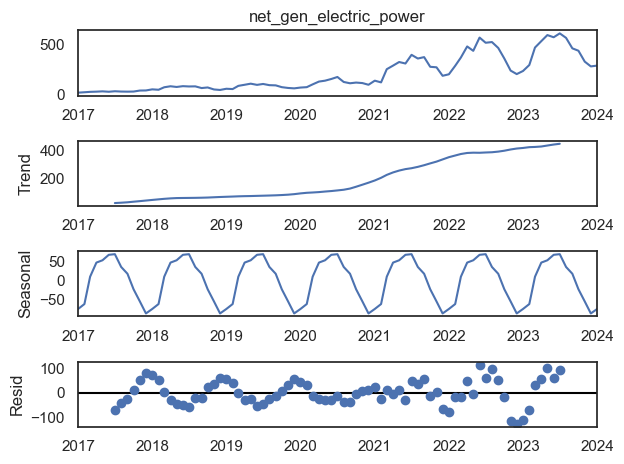

In [65]:
# Seasonal decomposition to identify and quantify the seasonality in the dataset
decomposed = seasonal_decompose(net_gen1['net_gen_electric_power'], model='additive')
decomposed.plot()
plt.show()

**Observation:** The seasonal decomposition plot of the net electricity generation time series data reveals a clear upward trend, indicating an increase in generation over time, which suggests growth in demand or capacity from 2017 onwards. The data exhibits a strong and consistent seasonal pattern, with regular peaks and troughs corresponding to certain times of the year, potentially reflecting seasonal variations in energy demand. The residual component shows random fluctuations around zero without any apparent pattern, indicating that the trend and seasonal components explain most of the variability in the data, and what remains is the irregular, unexplained noise. This decomposition is crucial for understanding the underlying patterns in the data and can significantly inform the development of accurate forecasting models. 

### Figure 3 - PACF and ACF 

/Users/crystal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


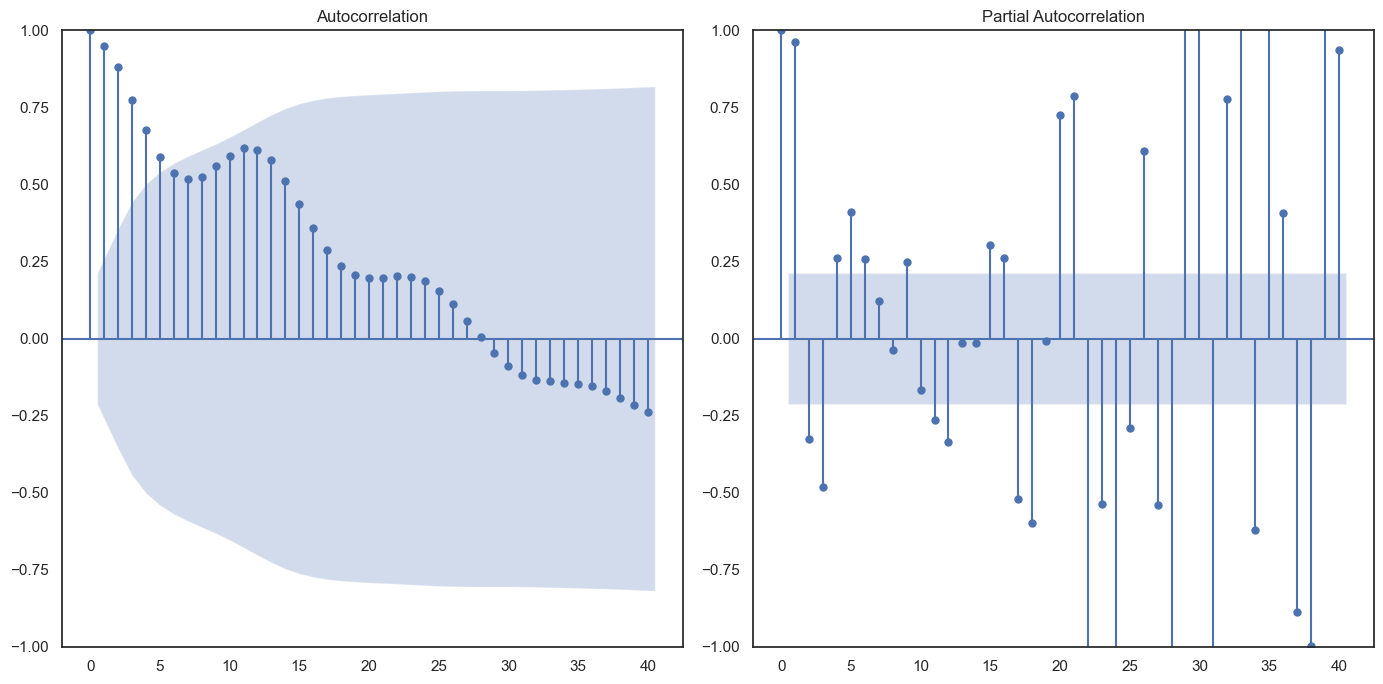

In [66]:
# Plot the ACF
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(net_gen1['net_gen_electric_power'], lags=40, ax=plt.gca())

# Plot the PACF
plt.subplot(122)
plot_pacf(net_gen1['net_gen_electric_power'], lags=40, ax=plt.gca())

plt.tight_layout()
plt.show()

**Observation:** <p>ACF Plot Shows a gradual decline in the autocorrelations, which do not cut off sharply. This indicates that the series is likely non-stationary, as it shows a long memory process where past values have a lingering effect on future values.<p>
The PACF Plot Displays significant spikes at the first few lags, which die out more gradually. The significance of the spikes indicates the lags that have a strong relationship with the current value after accounting for previous lags.

In [67]:
# ADF test for stationary
adf_test = adfuller(net_gen1)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.425311
p-value: 0.982417
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589


In [68]:
if adf_test[0] < adf_test[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

Failed to Reject Ho - Time Series is Non-Stationary


**Observation:** Given that the ADF statistic is not lower than any of the critical values and the p-value is greater than 0.05, you would fail to reject the null hypothesis. This means there's no statistical evidence to conclude that the time series is stationary. In practical terms, your time series likely contains a unit root and is non-stationary.I will need to difference the series or apply another transformation to attempt to make it stationary before fitting a time series model. 

### Figure 4 - Difference

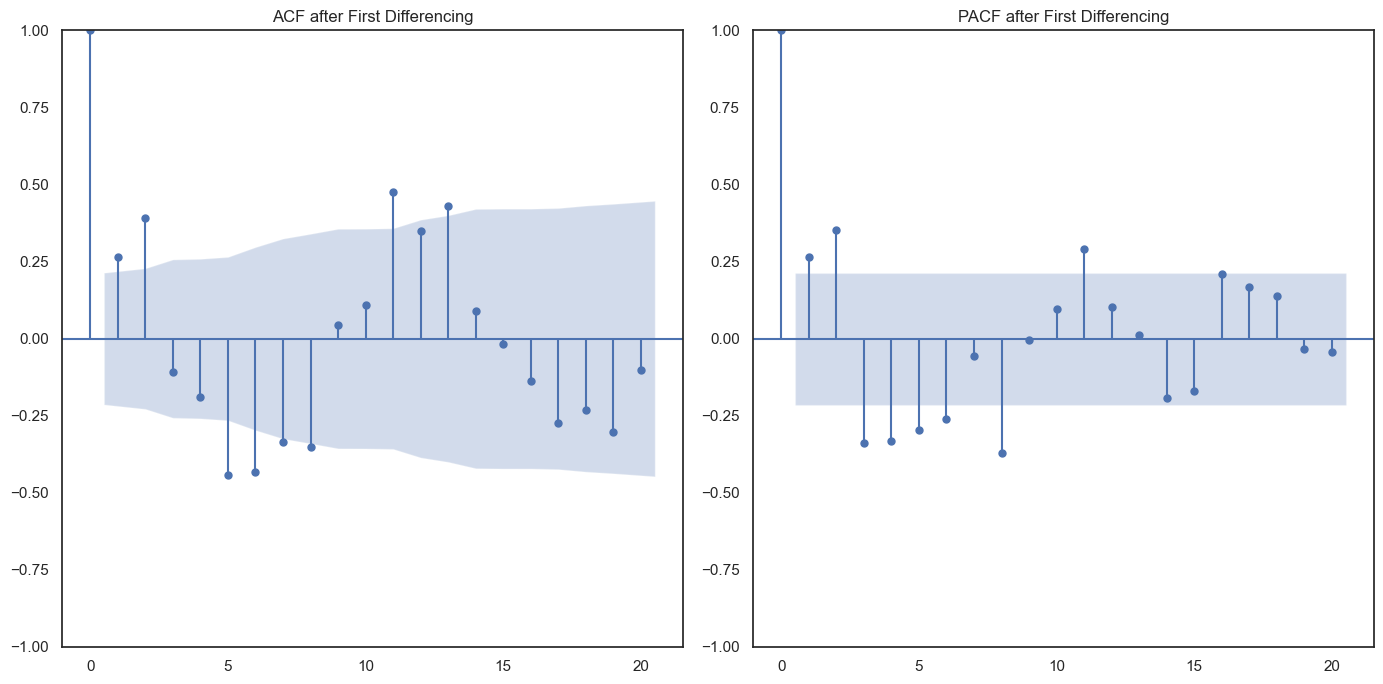

In [78]:
# Differencing the data to remove trends and seasonality
net_gen1['diff_net_gen'] = net_gen1['net_gen_electric_power'].diff()
diff_net_gen = net_gen1['diff_net_gen'].dropna()

# Plot the ACF
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(diff_net_gen, lags=20, ax=plt.gca())
plt.title('ACF after First Differencing')


# Plot the PACF
plt.subplot(122)
plot_pacf(diff_net_gen, lags=20, ax=plt.gca())
plt.title('PACF after First Differencing')

plt.tight_layout()
plt.show()


In [80]:
# ADF test for stationary
adf_test = adfuller(diff_net_gen)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[0] < adf_test[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.804824
p-value: 0.378069
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Failed to Reject Ho - Time Series is Non-Stationary


/Users/crystal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


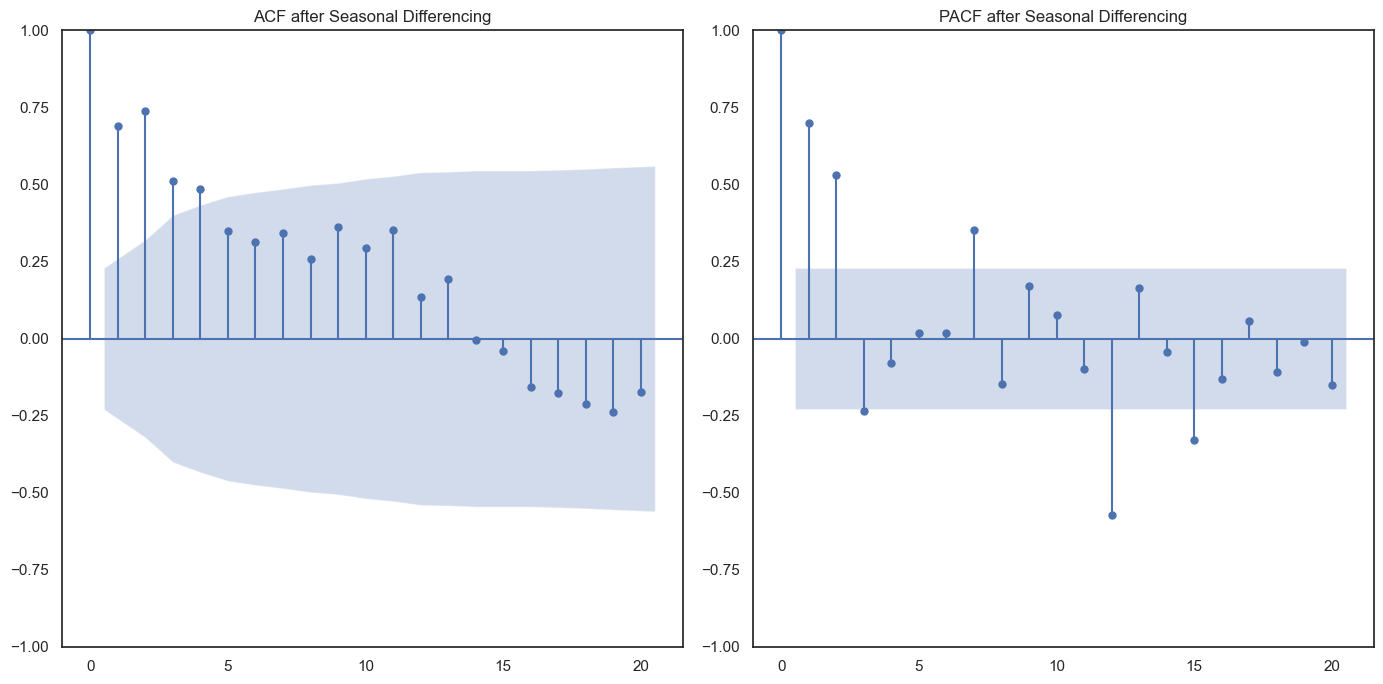

In [84]:
# Seasonal Difference to remove seasonality (assuming monthly data with yearly seasonality)
net_gen1['seasonal_diff'] = net_gen1['net_gen_electric_power'].diff(12)
seasonal_diff = net_gen1['seasonal_diff'].dropna()

# Plot the ACF
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(seasonal_diff, lags=20, ax=plt.gca())
plt.title('ACF after Seasonal Differencing')


# Plot the PACF
plt.subplot(122)
plot_pacf(seasonal_diff, lags=20, ax=plt.gca())
plt.title('PACF after Seasonal Differencing')

plt.tight_layout()
plt.show()


In [85]:
# ADF test for stationary
adf_test = adfuller(seasonal_diff)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[0] < adf_test[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.680409
p-value: 0.441233
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
Failed to Reject Ho - Time Series is Non-Stationary


/Users/crystal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


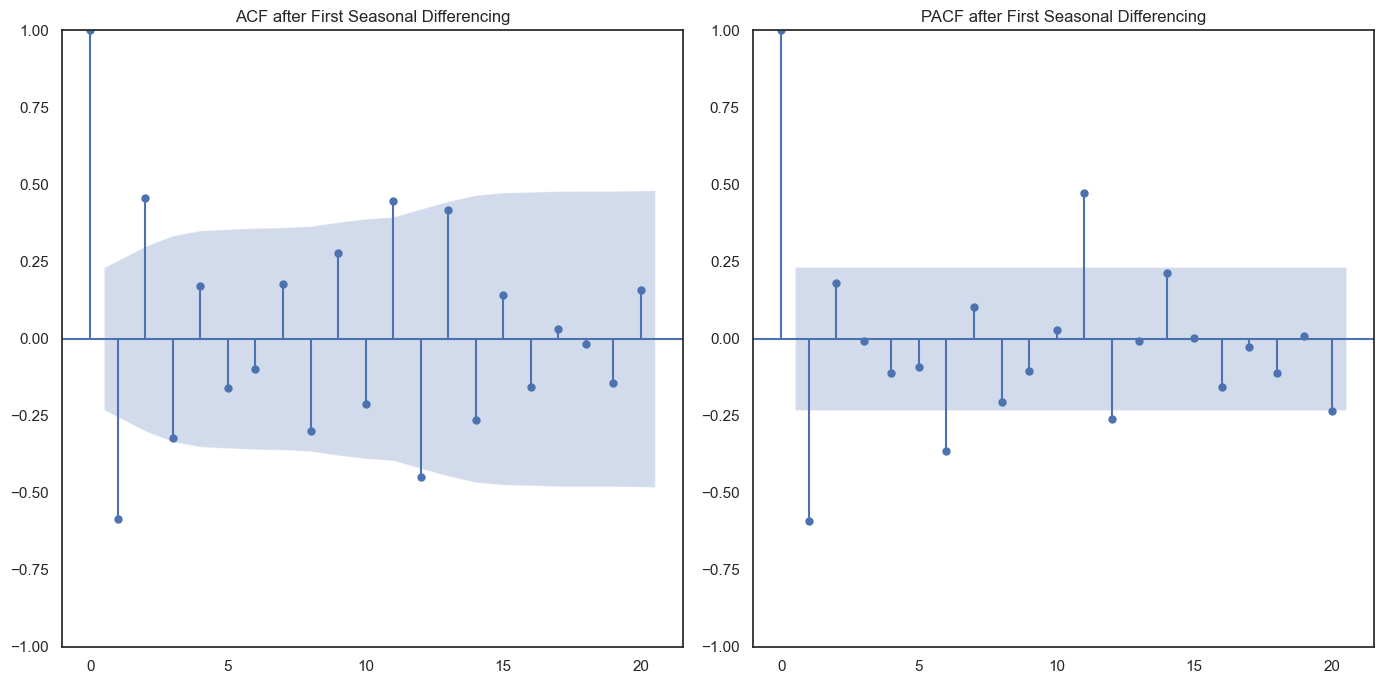

In [86]:
# Combination of first and seasonal differencing
net_gen1['first_seasonal_diff'] = net_gen1['diff_net_gen'].diff(12)
first_seasonal_diff = net_gen1['first_seasonal_diff'].dropna()

# Plot the ACF
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(first_seasonal_diff, lags=20, ax=plt.gca())
plt.title('ACF after First Seasonal Differencing')


# Plot the PACF
plt.subplot(122)
plot_pacf(first_seasonal_diff, lags=20, ax=plt.gca())
plt.title('PACF after First Seasonal Differencing')

plt.tight_layout()
plt.show()

In [87]:
# ADF test for stationary
adf_test = adfuller(first_seasonal_diff)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[0] < adf_test[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -2.210720
p-value: 0.202378
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
Failed to Reject Ho - Time Series is Non-Stationary


/Users/crystal/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


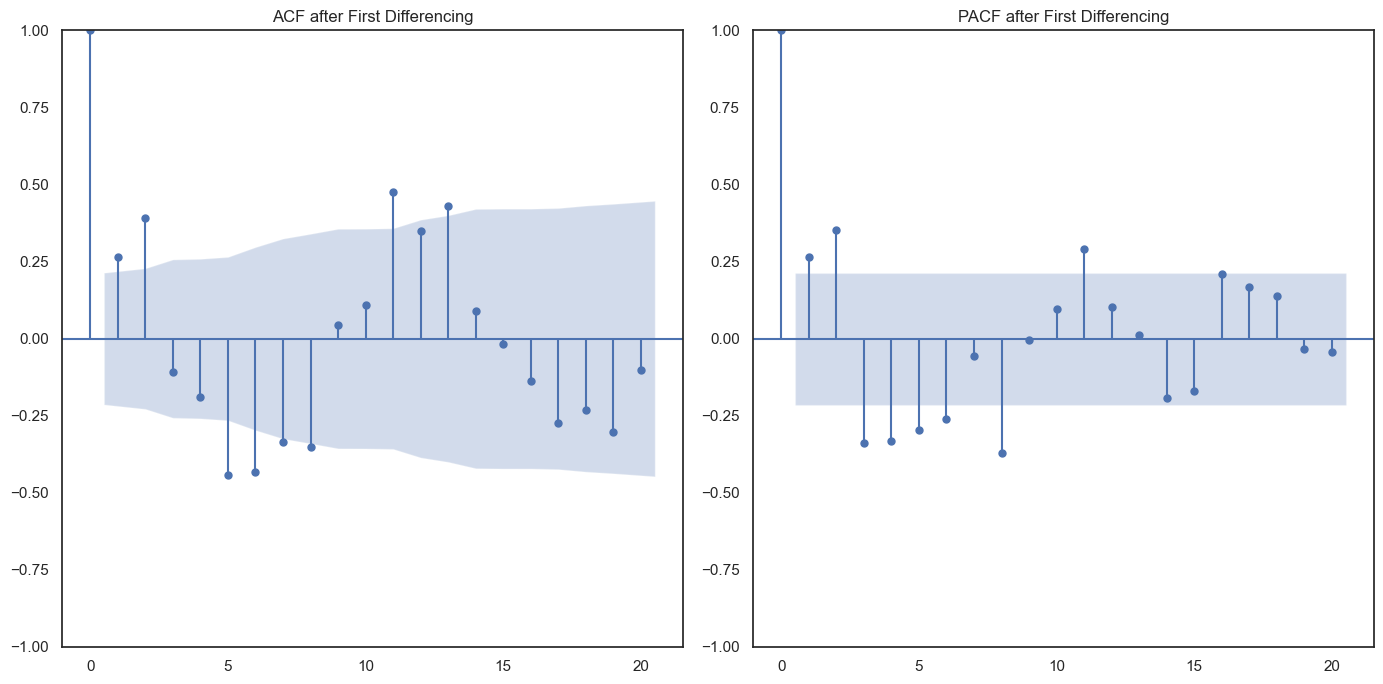

In [88]:
# Differencing the data to remove trends and seasonality
net_gen1['sec_diff_net_gen'] = net_gen1['net_gen_electric_power'].diff()
sec_diff_net_gen = net_gen1['sec_diff_net_gen'].dropna()

# Plot the ACF
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(sec_diff_net_gen, lags=20, ax=plt.gca())
plt.title('ACF after First Differencing')


# Plot the PACF
plt.subplot(122)
plot_pacf(sec_diff_net_gen, lags=20, ax=plt.gca())
plt.title('PACF after First Differencing')

plt.tight_layout()
plt.show()

In [89]:
# ADF test for stationary
adf_test = adfuller(sec_diff_net_gen)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[0] < adf_test[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.804824
p-value: 0.378069
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Failed to Reject Ho - Time Series is Non-Stationary


# Seasonal Difference to remove seasonality (assuming monthly data with yearly seasonality)
net_gen1['seasonal_diff'] = net_gen1['net_gen_electric_power'].diff(12)

# You might also consider a combination of first and seasonal differencing
net_gen1['first_seasonal_diff'] = net_gen1['first_diff'].diff(12)